# Snow Avalanche Hazard Mapping for Lake Tahoe


## Table of Contents

* [Introduction](#1)
* [Necessary imports](#2)
* [Connect to your GIS](#3)
* [Get the data for analysis](#5)
* [Clip and generate rasters from DEM](#11)
    * [Create elevation raster](#12)
    * [Create slope raster](#13)
    * [Create aspect raster](#14)
    * [Create curvature raster](#15)
* [Land Use and Land Cover raster](#16)
* [Snow avalanche vulnerability map](#18)
* [Conclusion](#19)
* [Data and literature resources](#20)

## Introduction <a class="anchor" id="1"></a>

According to the [National Avalanche Center](https://avalanche.org/national-avalanche-center/), every year 25 to 30 people die due to snow avalanches in USA, interestingly termed as "White Death". Record shows that snow avalanches have killed more people in forests than any other natural disaster, while they were participating in recreational activities.

Recently on Jan 17, 2020, a snow avalanche caused several people missing at the Alpine Meadows ski area and near lake Tahoe. Other than human casualty, it also creates blockage on roads and railway tracks and can even destroy power supply lines. Avalanches could be triggered by various reasons such as heavy snowfall, deforestation, vibrations, change in wind direction & speed, etc.

In view of this destructive power of avalanches a study is undertaken near the Lake Tahoe area, California to identify vulnerable locations that could be hit by snow avalanches. Weighted Linear Combination (WLC) method based on combined GIS and Remote Sensing techniques is used in the sample to create a potential hazard map for avalanches. It consists of three steps:

   -  Reclassify all the datasets in the same range

   - Assign scores to the categories of each dataset

   - Weight each dataset based on relative importance and add them together

## Necessary imports <a class="anchor" id="2"></a>

In [1]:
from arcgis.gis import GIS
import arcgis.raster.functions
from arcgis.raster.functions import aspect, clip, colormap, con, curvature, remap, slope       

## Connect to your GIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS(url='https://pythonapi.playground.esri.com/portal')

##  Get the data for analysis <a class="anchor" id="5"></a>

Avalanche is a dynamic hazard or in other words has a fast onset and offset period, with favorable conditions impacted by land use-landcover, elevation, slope, curvature, variations in weather. In this study, USA NLCD Land Cover data is used for land cover, and ASTER DEM is used for elevation, slope and curvature to create a potential snow avalanche hazard map for the Lake Tahoe area.

In [3]:
# Aster DEM
dem = gis.content.search("DEM Lake Tahoe", 'imagery layer')[0]
dem

<Item title:"DEM Lake Tahoe" type:Imagery Layer owner:api_data_owner>

In [4]:
lulc = gis.content.search("LULC Lake Tahoe", 'imagery layer')[0]
lulc

<Item title:"Lake Tahoe LULC" type:Imagery Layer owner:api_data_owner>

<Item title:"Study Area Tahoe" type:Feature Layer Collection owner:api_data_owner>
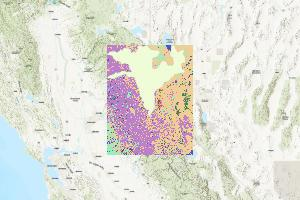

In [5]:
aoi = gis.content.search("study area tahoe", 'feature layer')[0]
aoi

Once the datasets are ready Weighted Linear Combination (WLC) is carried out. Here all the datasets were reclassified and scores were given to them so that all are in the same number scale. The  score ranges between 0 to 5, with high score implying extremely vulnerable area and low score indicating less vulnerable or safe areas.

In [6]:
# Weighted Linear Combination (WLC) 
aoi_layer = aoi.layers[0]
aoi_feature = aoi_layer.query(where='OBJECTID=1')
aoi_feature.features[0].extent = dem.layers[0].extent
aoi_geom = aoi_feature.features[0].geometry
aoi_geom['spatialReference'] = {'wkid':3857}

For further analysis, all the datasets were clipped with the AOI boundary.

## Clip and generate rasters from DEM <a class="anchor" id="11"></a>

ASTER DEM imagery layer was used in the study, having a spatial resolution of 30m. The DEM was clipped with the AOI boundary, followed by creating classified rasters of DEM elevation, slope, curvature and aspect rasters from it.

In [7]:
dem_clip = clip(dem.layers[0], aoi_geom)

In [8]:
m = gis.map('Lake Tahoe, California')
m.add_layer(dem_clip)
m.legend = True
m

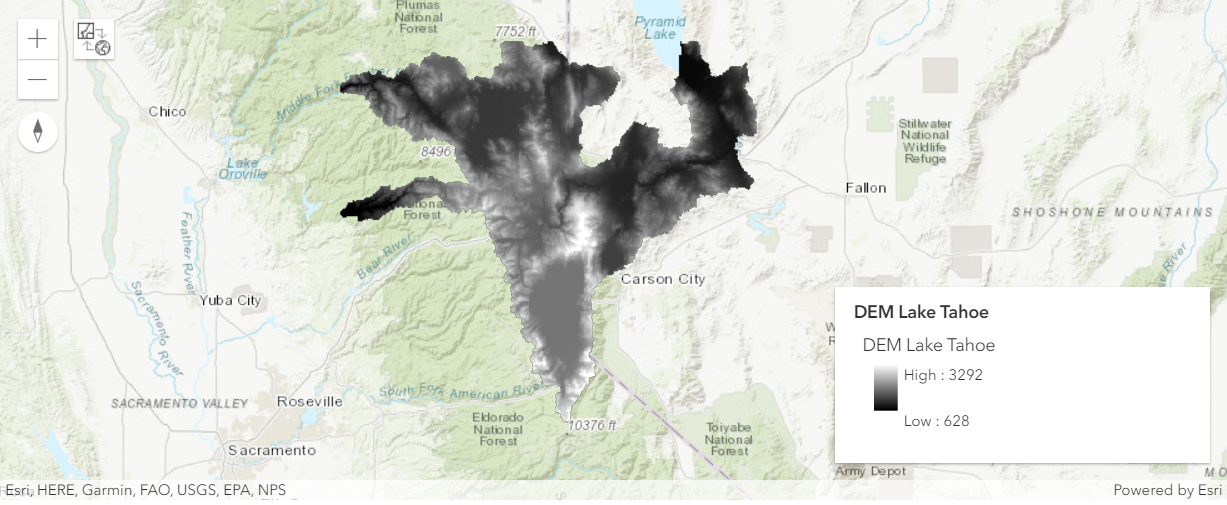

### Create elevation raster <a class="anchor" id="12"></a>

Elevation does not directly affect avalanche occurrences, but it impacts meteorological factors like temperature, wind speed, amount and type of precipitation which in turn affect the snowpack stability.

Generally, with an increase in elevation, the air temperature decreases while the wind speed increases. [Literature](http://www.indjst.org/index.php/indjst/article/view/105647) shows that most of the avalanches occur between 2700m to 6000m.

The study area DEM has elevation between 628m to 3292m. The elevation raster has been created by reclassifying the DEM. DEM was reclassified into 5 classes and scores were given to each class between 1 to 5 where 1 means not vulnerable and 5 means highly vulnerable to snow avalanche. The highest score of 5 was given to the elevation class 2345 to 3309 followed by 2002 to 2345 class with 4. A score of 1 was given to the elevation value between 612 to 1713 as the literature shows elevation below 2000m is less vulnerable for an avalanche.

In [9]:
elevation = colormap(remap(dem_clip,
                           input_ranges=[612, 1433,
                                         1433, 1713,
                                         1713, 2002,
                                         2002, 2345,
                                         2345, 3309],
                           output_values=[1, 2, 2, 4, 5],
                           astype='u8'),
                     colormap=[[1, 255, 255, 204], [2, 0, 100, 0],
                               [4, 255, 127, 80], [5, 255, 0, 0]])

In [10]:
m = gis.map('Lake Tahoe, California')
m.add_layer(elevation)
m.legend = True
m

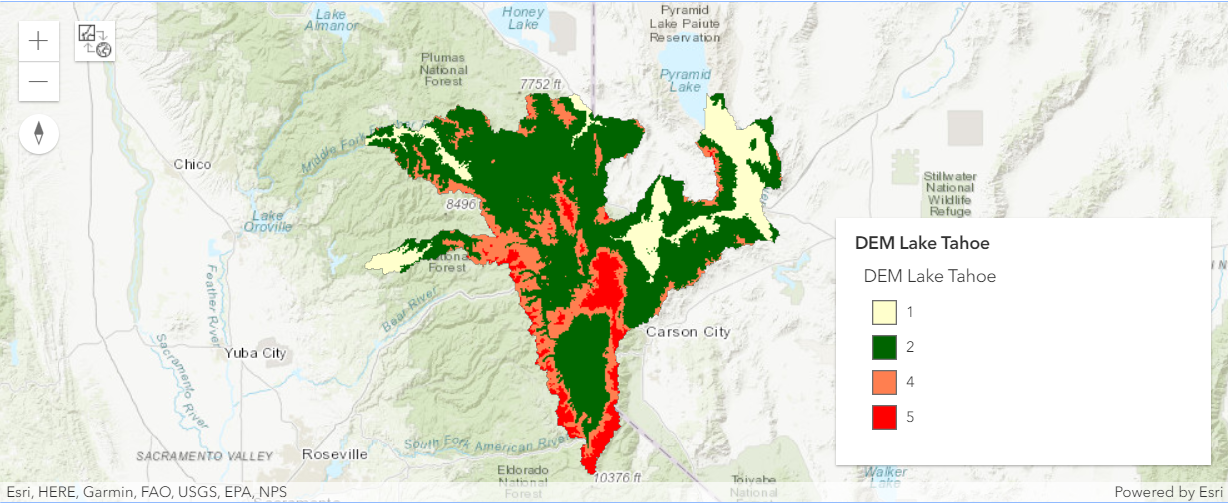

### Create slope raster<a class="anchor" id="13"></a>

Slope is one of the important factors for avalanche occurrences. According to the past studies, most of the avalanches occurred on a slope between 28 to 45 degrees. Thus, while slope less than 25 degrees is not prone to avalanches at the same time too steep slopes also do not cause avalanches since it does not allow snow to accumulate. In view of this the slope map was created and reclassified into 5 classes, with appropriate label.

In [11]:
slope = colormap(remap(slope(dem_clip),
                       input_ranges=[0,  12,  # Flat
                                     12, 28,  # Low
                                     28, 45,  # Highly vulnerable
                                     45, 55,  # Steep
                                     55, 90], # Very Steep
                       output_values=[1, 2, 5, 3, 2],
                       astype='u8'),
                 colormap=[[1, 141, 212, 0], [2, 255, 225, 204],
                           [5, 255, 0, 0]])

In [12]:
m = gis.map('Lake Tahoe, California')
m.add_layer(slope)
m.legend = True
m

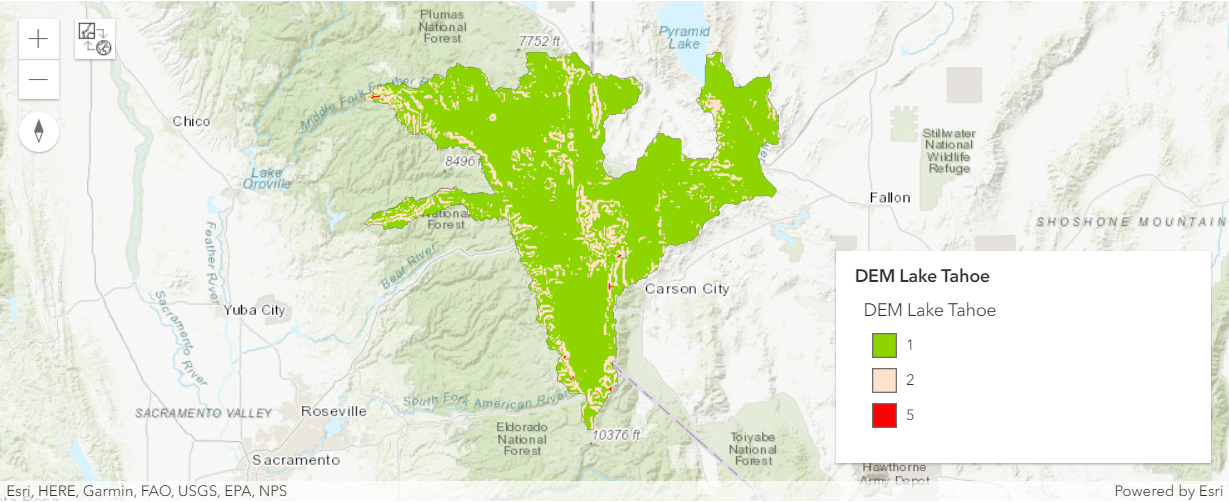

### Create aspect raster<a class="anchor" id="14"></a>

The snowpack stability is directly affected by the orientation of slope with respect to the sun. Snowpack on slopes facing the sun stabilizes faster in comparison to the snow on shaded slopes which remains unstable. Accordingly, the Aspect raster was reclassified into 5 classes and different scores were given to each class based on their orientation to the Sun.

In [13]:
aspect = colormap(remap(aspect(dem_clip),
                     input_ranges=[-1, 0, #Flat
                                   0, 22.5,  # North
                                   22.5, 67.5,  # Northeast
                                   67.5, 112.5,  # East 
                                   112.5, 157.5, # Southeast 
                                   157.5, 202.5, # South
                                   202.5, 247.5, # Southwest 
                                   247.5, 292.5, # West 
                                   292.5, 337.5, # Northwest
                                   337.5, 360], # North
                        output_values=[1, 5, 5, 1, 2, 1, 1, 1, 4, 5],
                        astype='u8'),
                  colormap=[[1, 255, 255, 204],[2, 255, 255, 0],
                            [4, 255, 178, 102],[5, 255, 0, 0]])

In [14]:
m = gis.map('Lake Tahoe, California')
m.add_layer(aspect)
m.legend = True
m

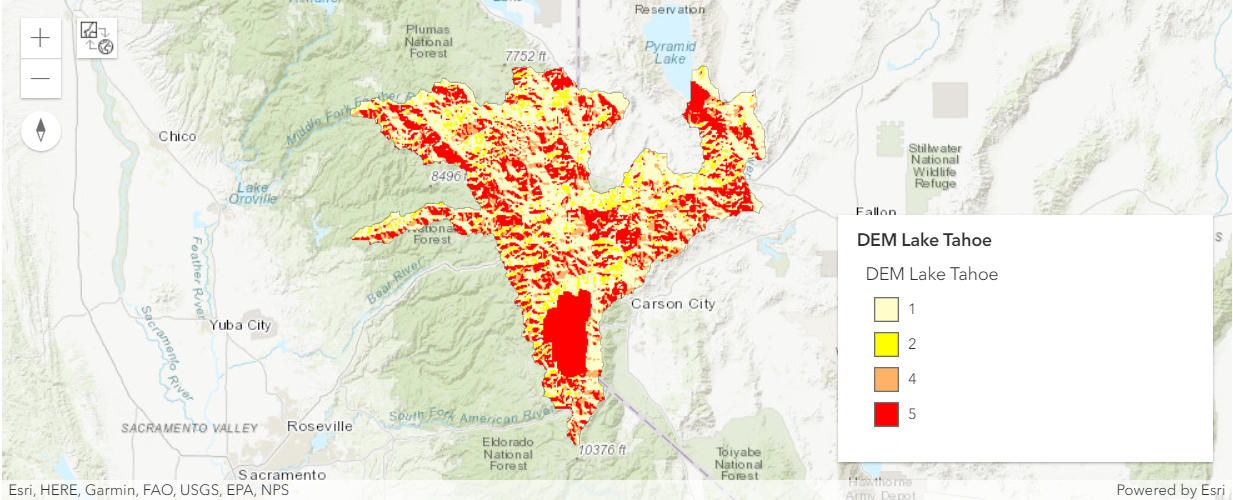

### Create curvature raster<a class="anchor" id="15"></a>

Curvature is also an important parameter for avalanche hazard prediction mapping. Snowpack over convex surfaces are more unstable than that on top of concave surfaces which usually can hold large amount of snow compared to convex surface.

Suitably, curvature raster was reclassified into 3 classes and convex slope was assigned the highest score of 5 as it was more vulnerable to avalanche, and 1 was assigned to concave surface as it was less vulnerable.

In [15]:
curvature = curvature(dem_clip, curvature_type='standard', z_factor=1, astype='F32')

In [16]:
curvature_s=colormap(remap(curvature,
                           input_ranges=[-60, 0, #concave slope
                                         0, 0, #flat slope 
                                         0.000001, 60], #convex slope
                             output_values=[1, 3, 5],
                             astype='F32'),
                       colormap=[[1, 255, 255, 204],
                                 [3, 255, 178, 102],
                                 [5, 255, 0, 0]])

In [17]:
m = gis.map('Lake Tahoe, California')
m.add_layer(curvature_s)
m.legend = True
m

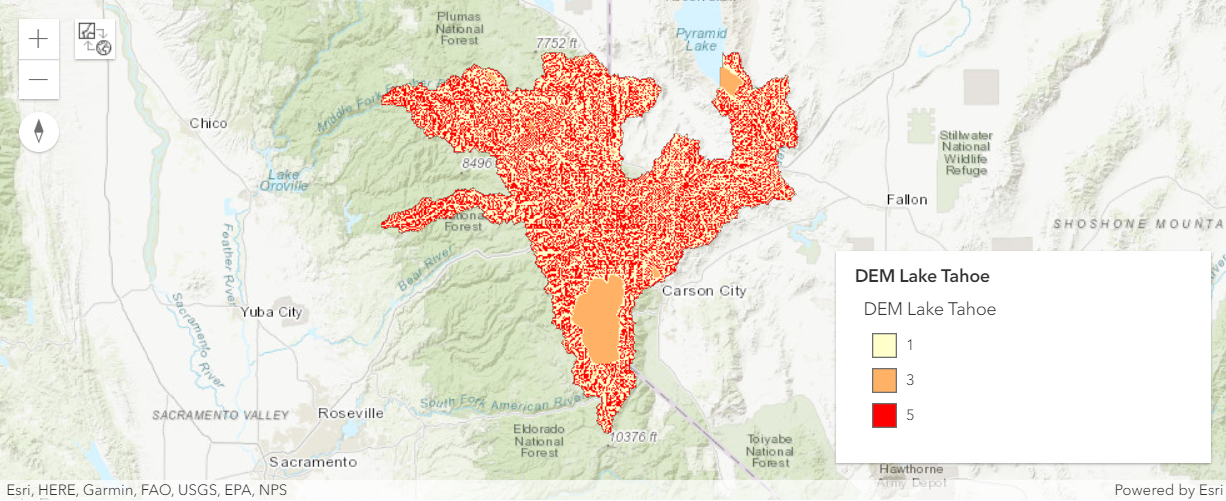

## Land Use and Land Cover raster<a class="anchor" id="16"></a>

In the study titled [USA NLCD Land Cover](https://www.arcgis.com/home/item.html?id=3ccf118ed80748909eb85c6d262b426f) ,[National Land Cover Database](https://www.mrlc.gov) was used from Living Atlas. Land Use and Land Cover(LULC) which represents the condition of the earth's surface is an important contributing factor for avalanches. For example areas with dense vegetation was less vulnerable than the areas with no vegetation and also snow and ice covered area were more prone to snow avalanches than barren land. 

This datatset has 20 land cover classes which includes vegetation type, development density, agricultural use, barren land, areas with water, snow and ice. The data was classified on the basis of modified Anderson Level II, and after clipping the LULC data with the AOI boundary, the data was resampled in 30m spatial resolution similar to the DEM data so that the overlay analysis can be done.  

In [18]:
lulc_clip = clip(lulc.layers[0], aoi_geom)

The study area has sixteen LULC classes. The raster was reclassified and scores were assigned to the LULC classes, with Snow & Ice class being highly vulnerable was scored as 5. Evergreen and mixed forests were less vulnerable to snow avalanche, so a low score was provided, while barren land, grassland and shrublands being moderately vulnerable, a score of 3 was assigned to them.

In [19]:
lulc_c = colormap(remap(lulc_clip,
                        input_ranges=[1, 1, #Open Water
                                      2, 2, #Perennial Snow/Ice
                                      3, 3,  #Developed Open Space
                                      4, 4, #Developed Low Intensity
                                      5, 5, # Developed Medium Intensity
                                      6, 6, #Developed High Intensity
                                      7, 7, #Barrenland
                                      8, 8, #Deciduous Forest
                                      9, 9, #Evergreen Forest
                                      10, 10, #Mixed Forest
                                      11, 11, #Shrub/Scrub
                                      12, 12, #Grassland/ Herbaceous
                                      13, 13, #Pasture/ Hay
                                      14, 14, #Cultivated Crops
                                      15, 15, #Woody Wetlands
                                      16, 16], #Emergent Herbaceous Wetlands
                        output_values=[1, 5, 1, 1, 1, 1, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2],
                        astype='u8'),
                  colormap=[[1, 0,100, 0], [2, 154, 205, 50],
                            [3, 255, 255, 0], [4, 255, 127, 80],
                            [5, 255, 0, 0]])

In [20]:
m = gis.map('Lake Tahoe, California')
m.add_layer(lulc_c)
m.legend = True
m

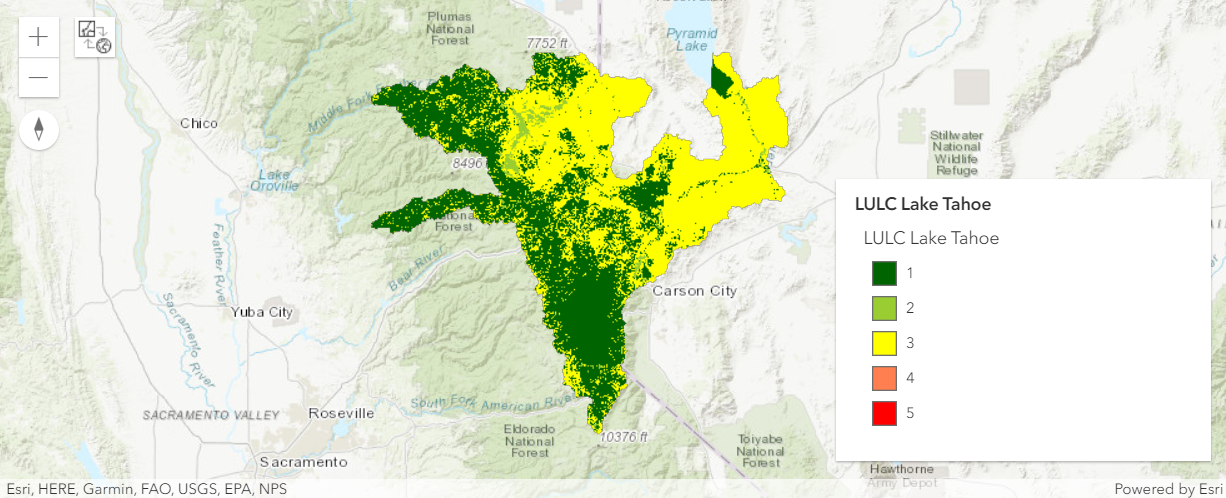

## Snow avalanche vulnerability map <a class="anchor" id="18"></a>

The final risk map is created by again weighting and combining (WLC) all the above six parameters based on relative importance, with the total weight summing up to 1 after being added so that the output can be consistent. 

In [21]:
risk_map = (0.4*elevation+0.1*slope+0.3*aspect+0.15*curvature_s+0.05*lulc_c)

In [22]:
avalanche_risk_map = colormap(risk_map,
                         colormap=[[1, 0,100, 0], [2, 154, 205, 50],
                                   [3, 255, 255, 0,], [4, 255, 127, 80], 
                                   [5, 255, 0, 0]],
                         astype='u8')

In [23]:
m = gis.map('Lake Tahoe, California')
m.add_layer(avalanche_risk_map)
m.legend = True
m

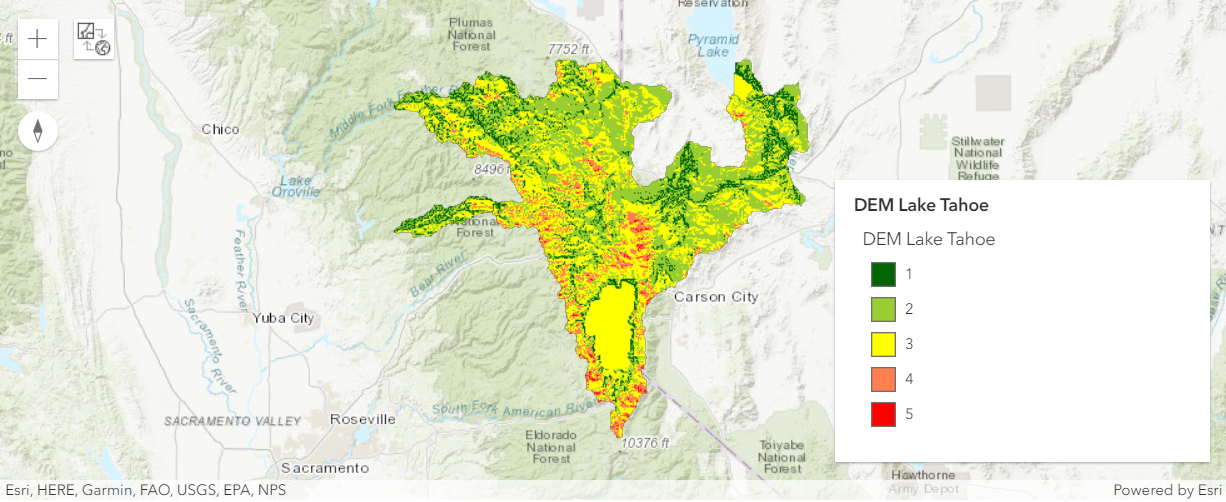

The final output potential avalanche hazard map has values from 1 to 5 with vulnerability increasing from 1 to 5. To make the numerical categories more meaningful the classes are labelled with suitable text description (done in ArcGIS Pro using `Raster Symbology`).

In [24]:
m = gis.map('Lake Tahoe, California')
m.add_layer(avalanche_risk_map)
m.legend = True
m

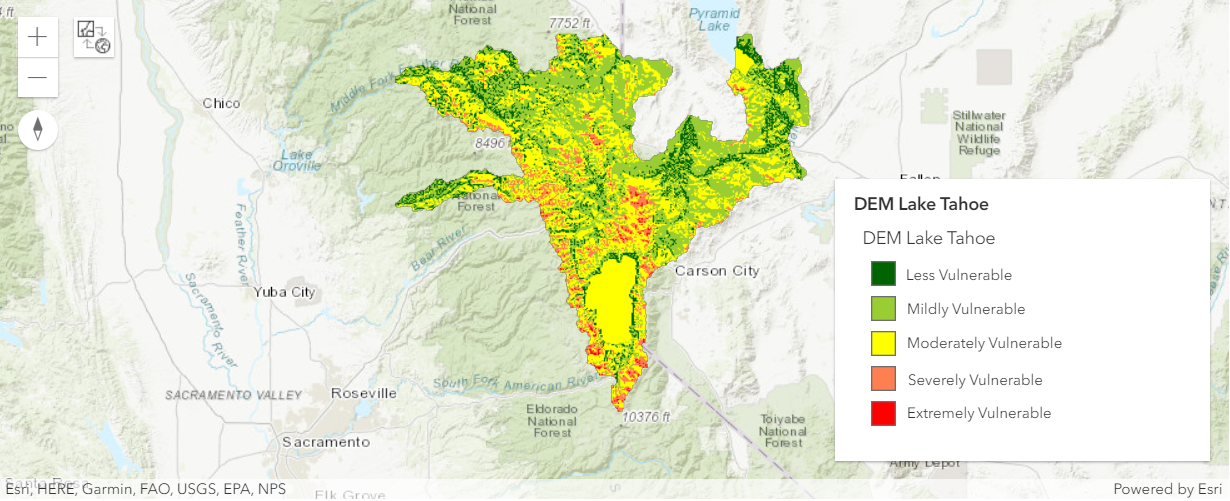

Red pixels in the map here has the steepest convex slopes and shows area which are extremely vulnerable to avalanches. The Tahoe lake is moderately vulnerable. As discussed above, the areas above 2000m elevation are more vulnerable, dark green and green colour is showing areas less vulnerable to snow avalanche.

## Conclusion <a class="anchor" id="19"></a>

Lake Tahoe experiences snow avalanches almost every year which causes deaths. In this sample, raster functions were used to create snow avalanche hazard map. Rasters were created from DEM, slope, aspect and curvature along with LULC map. WLC model is widely acceptable for natural disasters mapping, and is also able to handle and integrate large volume of data hence the model was incorporated with GIS to create the hazard map. The same workflow can be used to create avalanche hazard map for different regions.

## Data and literature resources<a class="anchor" id="20"></a>

| Data and literature | Source | Link |
| -| - |-|
| ASTER DEM| Earthdata  |https://search.earthdata.nasa.gov/|
| Land Cover data  |USA NLCD Land Cover data  |http://www.arcgis.com/home/item.html?id=3ccf118ed80748909eb85c6d262b426f
| Research Paper   | Snow Avalanche Susceptibility Mapping using Remote Sensing and GIS in Nubra-Shyok Basin, Himalaya, India  |http://www.indjst.org/index.php/indjst/article/view/105647
| Research Paper   |Potential Hazard Map for Snow Disaster Prevention Using GIS-Based Weighted Linear Combination Analysis and Remote Sensing Techniques: A Case Study in Northern Xinjiang, China  |http://www.scirp.org/journal/ars http://dx.doi.org/10.4236/ars.2014.34018|
| Research Paper   |Landslide vulnerability mapping (LVM) using weighted linear combination (WLC) model through remote sensing and GIS techniques  |https://link.springer.com/article/10.1007/s40808-016-0141-7|